The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


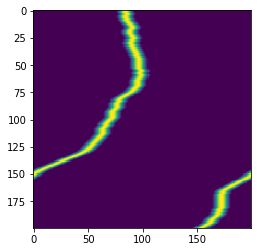

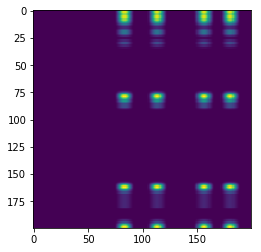

(200,) (200, 200)


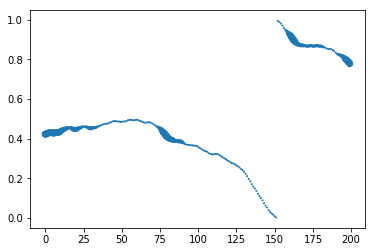

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
%load_ext autoreload
%autoreload 2



def bump(n, x, w=10, wrap=True):
    x = x%1.
    v = np.zeros(n)
    domain = np.linspace(-np.pi,np.pi, num=w)

    if wrap:
        mu = int(x*n)
        v[np.arange(mu-w//2,mu+w//2)%n] += np.cos(domain)*0.5+ .5
    else:
        mu = int(x*(n-w - 1))
        v[np.arange(mu,mu+w)] += np.cos(domain)*0.5+ .5
    return v
    
def create_environment(n, k=1, w=10):
    v = np.zeros(n)
    x = np.linspace(-np.pi,np.pi, num=w)
#     lms = np.random.choice(n, size=k, replace=False)
    lms = np.random.sample(k)
    
    for l in lms:
        lm = int(l*n)

        v[np.arange(lm-w//2,lm+w//2)%n] += np.cos(x)*0.5+ .5
        
    np.clip(v, 0.,1., v)
    
    return v, lms

# plt.plot(e)


def random_walk(n, T, start=None):
    X = np.zeros(T)
    V = np.zeros(T)
    
    if start is None:
        X[0] = np.random.sample()
    else:
        X[0] = start

    v = 0.
    a = 0.001
    for t in range(1,T):
        r = np.random.randn()
        r = max(min(r, a), -a)
        v = v + 2*r
        v = max(min(0.04, v), -0.04)
        X[t] = X[t-1] + v
    
    
    V[:-1] = X[1:] - X[:-1]
    return X, V

def x_to_placecode(X, n, w):
    T = X.shape[0]
    C = np.zeros((T,n))
    for t in range(T):
        C[t] = bump(n,X[t], w)
        
    return C

def at_landmark_signal(X, env):
    return env[(n*(X%1.)).astype(int)].reshape((-1,1))

n = 200
h = 500
w = 20
T = 200


e, lms = create_environment(n,4, w)
X, V = random_walk(n,T=T, start=np.random.choice(lms))
C = x_to_placecode(X,n,w)

at_LM = at_landmark_signal(X,e)

plt.imshow(C)
plt.show()


lm_input = at_LM*e
plt.imshow(lm_input)
plt.show()

plt.scatter(np.arange(T), X%1., s=1. + at_LM*40., marker="o")

print V.shape, C.shape


In [449]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



dtype = torch.float

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.rec = nn.Linear(input_size + hidden_size, hidden_size)
        self.dec = nn.Linear(hidden_size, output_size)
#         torch.nn.init.xavier_uniform(conv1.weight)
        torch.nn.init.xavier_uniform_(self.rec.weight)
        torch.nn.init.xavier_uniform_(self.dec.weight)
        
#         self.dropout = nn.Dropout(0.1)


    def forward(self, X, hidden):

        input_combined = torch.cat((X, hidden),1)
        hidden = F.relu(self.rec(input_combined))
        output = F.relu(self.dec(hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, dtype=dtype)


n=60
h=128
T=100
w=6

rnn = RNN(input_size=n+20, hidden_size=h, output_size=n)
    
print rnn
    
criterion = nn.MSELoss(reduction='elementwise_mean')

learning_rate = 0.001


def train(input_line_tensor, target_line_tensor):
    

    
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0.


    for i in range(input_line_tensor.size(0)):
        x = input_line_tensor[[i]]
        output, hidden = rnn(x, hidden)
        l = criterion(output, target_line_tensor[[i]])
        loss += l


    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)



RNN(
  (rec): Linear(in_features=208, out_features=128, bias=True)
  (dec): Linear(in_features=128, out_features=60, bias=True)
)


In [450]:



e, lms = create_environment(n,4, w)
X, V = random_walk(n,T=T)
C = x_to_placecode(X,n,w)


C = np.concatenate([C, V.reshape((-1,1))],axis=1)

at_LM = at_landmark_signal(X,e)
lm_input = at_LM*e





n_iters = 10000
print_every = 100
plot_every = 1
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):

    e, lms = create_environment(n,1, w)
    Pos, V_ = random_walk(n,T=T, start=np.random.choice(lms))
    PC = x_to_placecode(Pos,n,w)
    V_ = (V_ + 0.01)/0.01
    V = np.zeros((T,20))
    for t in range(T):
        V[t] =  bump(20, V_[t], w=6,wrap=False)

    at_LM = at_landmark_signal(Pos,e)
    lm_input = at_LM*e
    
    C = np.concatenate([V.reshape((-1,20)), lm_input],axis=1)
    
    
    X = torch.from_numpy(C)
    Y = torch.from_numpy(PC)
    X= X.type(dtype)
    Y= Y.type(dtype)
    
    output, loss = train(X, Y)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
        

0m 3s (100 0%) 0.0323
0m 7s (200 0%) 0.0314
0m 10s (300 0%) 0.0307
0m 14s (400 0%) 0.0314
0m 17s (500 0%) 0.0308
0m 21s (600 0%) 0.0313
0m 24s (700 0%) 0.0309
0m 28s (800 0%) 0.0305
0m 32s (900 0%) 0.0306
0m 35s (1000 0%) 0.0309
0m 39s (1100 0%) 0.0307
0m 42s (1200 0%) 0.0310
0m 46s (1300 0%) 0.0308
0m 49s (1400 0%) 0.0299
0m 53s (1500 0%) 0.0306
0m 56s (1600 0%) 0.0311
1m 0s (1700 0%) 0.0302
1m 4s (1800 0%) 0.0308
1m 7s (1900 0%) 0.0306
1m 11s (2000 0%) 0.0307
1m 14s (2100 0%) 0.0305
1m 18s (2200 0%) 0.0311
1m 21s (2300 0%) 0.0305
1m 25s (2400 0%) 0.0308
1m 28s (2500 0%) 0.0306
1m 32s (2600 0%) 0.0298
1m 36s (2700 0%) 0.0307
1m 39s (2800 0%) 0.0306
1m 43s (2900 0%) 0.0304
1m 46s (3000 0%) 0.0310
1m 50s (3100 0%) 0.0305
1m 53s (3200 0%) 0.0308
1m 57s (3300 0%) 0.0308
2m 0s (3400 0%) 0.0302
2m 4s (3500 0%) 0.0305
2m 8s (3600 0%) 0.0305
2m 11s (3700 0%) 0.0305
2m 15s (3800 0%) 0.0305
2m 18s (3900 0%) 0.0306
2m 22s (4000 0%) 0.0306
2m 25s (4100 0%) 0.0306
2m 29s (4200 0%) 0.0303
2m 32s (4

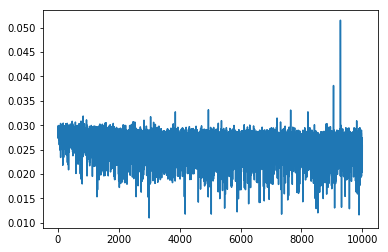

In [415]:
plt.plot(all_losses)

In [443]:
e, lms = create_environment(n,1, w)
Pos, V_ = random_walk(n,T=T, start=np.random.choice(lms))
PC = x_to_placecode(Pos,n,w)

V_ = (V_ + 0.01)/0.01
V = np.zeros((T,20))
for t in range(T):
    V[t] =  bump(20, V_[t], w=6, wrap=False)

at_LM = at_landmark_signal(Pos,e)
lm_input = at_LM*e

C = np.concatenate([V.reshape((-1,20)), lm_input],axis=1)
X = torch.from_numpy(C)
Y = torch.from_numpy(lm_input)
X= X.type(dtype)
Y= Y.type(dtype)

    
hidden = rnn.initHidden()

rnn.zero_grad()
for t in range(X.size(0)):
    x = X[[t]]
    output, hidden = rnn(x, hidden)
    Y[t] = output

RuntimeError: size mismatch, m1: [1 x 280], m2: [270 x 200] at /Users/soumith/miniconda2/conda-bld/pytorch_1532620281745/work/aten/src/TH/generic/THTensorMath.cpp:2070

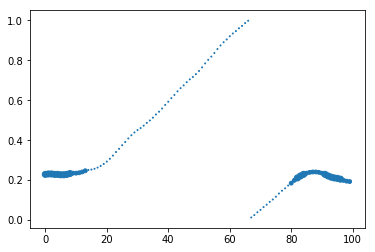

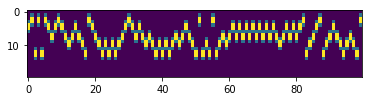

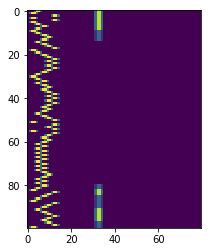

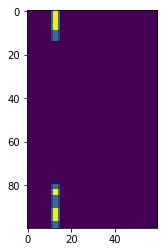

In [444]:

plt.scatter(np.arange(T), Pos%1., s=1. + at_LM*40., marker="o")
# plt.scatter(np.arange(T), V_, s=1. + at_LM*40., marker="o")
plt.show()

plt.show()
plt.imshow( X.detach().numpy()[:,:20].T)
plt.show()
plt.imshow( X.detach().numpy() )
plt.show()
plt.imshow(Y.detach().numpy())